## Optional first step installing packages

In [16]:
import sys
!{sys.executable} -m pip install geofeather
!{sys.executable} -m pip install nhdnet  #see Setup info document 

### Loading modules

In [17]:
from pathlib import Path
import os
from time import time
import geopandas as gp


from geofeather import to_geofeather
from nhdnet.nhd.extract import extract_flowlines
#from nhdnet.nhd.extract, extract_waterbodies
from nhdnet.io import serialize_df, serialize_sindex, to_shp

## Intial setup and constanst

In [18]:
HUC2 = 10
i = 19
HUC4 = "{0}{1:02d}".format(HUC2, i)
print(HUC4)
print(type(HUC4))
huc_id = int(HUC4) * 1000000
print(huc_id)

#Setting projections
CRS = {
    "proj": "aea",
    "lat_1": 29.5,
    "lat_2": 45.5,
    "lat_0": 37.5,
    "lon_0": -96,
    "x_0": 0,
    "y_0": 0,
    "datum": "NAD83",
    "units": "m",
    "no_defs": True,
}

1019
<class 'str'>
1019000000


## Read in the geodatabase

In [19]:
gdb ="1019/NHDPLUS_H_{HUC4}_HU4_GDB.gdb".format(HUC4=HUC4)
print(gdb)
read_start = time()
flowlines, joins = extract_flowlines(gdb, target_crs=CRS)
print("Read {:,} flowlines in  {:.0f} seconds".format(len(flowlines), time() - read_start))

1019/NHDPLUS_H_1019_HU4_GDB.gdb
Reading flowlines


DriverError: 1019/NHDPLUS_H_1019_HU4_GDB.gdb: No such file or directory

## Getting information about what came out of this

First for the flowlines -- this is a geodataframe with the flowline geometry

['geometry', 'lineID', 'NHDPlusID', 'FType', 'length', 'sinuosity', 'sizeclass', 'streamorder']


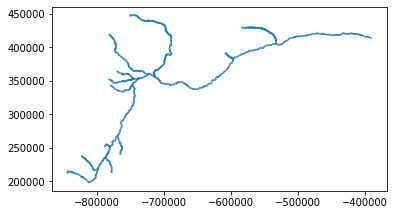

In [41]:
type(flowlines)
#flowlines.head(3)
#print(flowlines.describe)
#flowlines.plot()
#print(flowlines.shape)
print(list(flowlines.columns))
#flowlines[flowlines.streamorder>6]
flowlines[flowlines.streamorder>6].plot()

Then for the joins - this is a dataframe with the linkage information

In [45]:
type(joins)
joins.head(3)
#print(joins.describe)

,upstream,downstream,upstream_id,downstream_id,type
0,0,23001900145002,0,1019106322,origin
1,0,23001900145006,0,1019106326,origin
2,0,23001900145007,0,1019106327,origin


## Reorganizing the columns (not really sure why they do this)

In [12]:
flowlines= flowlines[["geometry",
                 "lineID",
                 "NHDPlusID",
                "FType",
                "length",
                "sinuosity",
                "sizeclass",
                "streamorder"]]
print(flowlines.shape)
#print(max(flowlines['NHDPlusID']), min(flowlines['NHDPlusID']))
#print(max(flowlines['lineID']), min(flowlines['lineID']))



(221415, 8)
23001900232509 23001900000001
232510 1


In [13]:
# Calculate lineIDs to be unique across the regions
#LC - .loc Accesses a group of rows and columns by label(s) or a boolean array
flowlines["lineID"] += huc_id
# Set updated lineIDs with the HUC4 prefix
joins.loc[joins.upstream_id != 0, "upstream_id"] += huc_id
joins.loc[joins.downstream_id != 0, "downstream_id"] += huc_id
joins.head(3)

,upstream,downstream,upstream_id,downstream_id,type
0,0,23001900145002,0,1019106322,origin
1,0,23001900145006,0,1019106326,origin
2,0,23001900145007,0,1019106327,origin


## Need to figure out what the read water bodies part is doing--- that function doesnt work in the sourced library but exists in the git repo
Check if we need to have the water bodies in order to have a fully connected drainage network or not

## Getting rid of dead ends
Note in this example there are none so nothing changes
~ means take the compliment

In [14]:
print(joins.shape)
joins=joins.loc[~((joins.downstream == 0) & (joins.upstream == 0))].copy()
print(joins.shape)

(311186, 5)
(311186, 5)


# Serializing the flowlines --- not sure exactly what this means
Blog post on to_geofeather: https://medium.com/@brendan_ward/introducing-geofeather-a-python-library-for-faster-geospatial-i-o-with-geopandas-341120d45ee5 
reset_index explanation: https://www.geeksforgeeks.org/reset-index-in-pandas-dataframe/

In [15]:
print("serializing {:,} flowlines to feather".format(len(flowlines)))
region_dir=Path(HUC4)
flowlines = flowlines.reset_index(drop=True)
to_geofeather(flowlines, region_dir /"flowlines.feather")
#Serializes a pandas DataFrame to a feather file on disk --- just writing it efficientely
serialize_df(joins,  "flowline_joins.feather", index=False)


serializing 221,415 flowlines to feather


###  Not part of the workflow just testing out  joins to see how they made that table 
This is copied from extract.py

In [35]:
print("Reading flowline joins")

#this line reads the flowlines and grabs out just the columns 'FromNHDPID' and 'ToNHDPID' then it renames them as upstream and downstream
join_df = gp.read_file(gdb, layer="NHDPlusFlow")[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
join_df.upstream = join_df.upstream.astype("uint64")
join_df.downstream = join_df.downstream.astype("uint64")



#join_df = (join_df.join(df.lineID.rename("upstream_id"), on="upstream").
#           join(df.lineID.rename("downstream_id"), on="downstream")
#           .fillna(0))

#test=flowlines[0:3]
#print(test)
#print(test.FType)
#test.FType.rename("testing")
print(test)



Reading flowline joins
          FromNHDPID      ToNHDPID
0       0.000000e+00  2.300190e+13
1       0.000000e+00  2.300190e+13
2       0.000000e+00  2.300190e+13
3       0.000000e+00  2.300190e+13
4       0.000000e+00  2.300190e+13
...              ...           ...
324348  0.000000e+00  2.300190e+13
324349  2.300190e+13  2.300190e+13
324350  0.000000e+00  2.300190e+13
324351  2.300190e+13  2.300190e+13
324352  0.000000e+00  2.300190e+13

[324353 rows x 2 columns]


In [33]:
#grabbing two columns out
print(join_df.shape)
test=join_df[["FromNHDPID", "ToNHDPID"]]
print(test.shape)
test.head(3)

(324353, 12)
(324353, 2)


,FromNHDPID,ToNHDPID
0,0.0,2.300190e+13
1,0.0,2.300190e+13
2,0.0,2.300190e+13


In [34]:
#Grabbing two coulmns out and modifying 

test2=join_df[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
test2.head(3)

,upstream,downstream
0,0.0,2.300190e+13
1,0.0,2.300190e+13
2,0.0,2.300190e+13


## Reading in the NABD shape file
Usefull tips on working with shape files: https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/

In [21]:
NABD = gp.read_file('./nabd_fish_barriers_2012/nabd_fish_barriers_2012.shp')


,COMMENT,NIDID,COMID,UNIQUE_STR,newX,newY,RecordID,Dam_name,Dam_former,STATEID,...,Spill_type,Num_locks,Len_locks,Wid_locks,Source,Condition,Cond_Date,Cond_desc,Spill_wid,geometry
0,1,AL00288,893441.0,1,-86.196373,31.424403,326.0,DONALDSON LAKE DAM,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.19637 31.42440)
1,1,AL01925,894119.0,2,-86.400374,31.170262,1679.0,CHARLES WOODHAM LAKE,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.40037 31.17026)
2,1,AL00648,895019.0,3,-86.299755,31.223052,641.0,JERRY ADAMS,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.29975 31.22305)


In [22]:
#look at the properties

In [30]:
print(NABD.shape)
print(list(NABD.columns))
NABD.head(3)

(52456, 56)
['COMMENT', 'NIDID', 'COMID', 'UNIQUE_STR', 'newX', 'newY', 'RecordID', 'Dam_name', 'Dam_former', 'STATEID', 'Section', 'County', 'River', 'City', 'Distance', 'Owner_name', 'Owner_type', 'Dam_type', 'Core', 'Foundation', 'Purposes', 'Year_compl', 'Year_modif', 'Dam_length', 'Dam_height', 'NID_height', 'Hazard', 'EAP', 'Inspection', 'Outlet_gat', 'Volume', 'State', 'Dam_Name2', 'Designer', 'Private', 'Str_Height', 'Hyd_Height', 'Max_Disch', 'Max_stor', 'Norm_stor', 'NID_stor', 'Surf_area', 'Drain_area', 'Insp_Freq', 'St_reg', 'St_reg_ag', 'Spill_type', 'Num_locks', 'Len_locks', 'Wid_locks', 'Source', 'Condition', 'Cond_Date', 'Cond_desc', 'Spill_wid', 'geometry']


,COMMENT,NIDID,COMID,UNIQUE_STR,newX,newY,RecordID,Dam_name,Dam_former,STATEID,...,Spill_type,Num_locks,Len_locks,Wid_locks,Source,Condition,Cond_Date,Cond_desc,Spill_wid,geometry
0,1,AL00288,893441.0,1,-86.196373,31.424403,326.0,DONALDSON LAKE DAM,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.19637 31.42440)
1,1,AL01925,894119.0,2,-86.400374,31.170262,1679.0,CHARLES WOODHAM LAKE,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.40037 31.17026)
2,1,AL00648,895019.0,3,-86.299755,31.223052,641.0,JERRY ADAMS,None,None,...,None,0.0,0.0,0.0,AL,None,None,None,0.0,POINT (-86.29975 31.22305)
